In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import os

for dirname, _, filenames in os.walk('../data/raw'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/raw/sales_test.csv
../data/raw/.DS_Store
../data/raw/solution.csv
../data/raw/sales_train.csv
../data/raw/calendar.csv
../data/raw/test_weights.csv
../data/raw/inventory.csv


In [3]:
calendar = pd.read_csv('../data/raw/calendar.csv')
test_weights = pd.read_csv('../data/raw/test_weights.csv')
inventory = pd.read_csv('../data/raw/inventory.csv')
sales_train = pd.read_csv('../data/raw/sales_train.csv')
sales_test = pd.read_csv('../data/raw/sales_test.csv')
solution = pd.read_csv('../data/raw/solution.csv')

We need to predict the sales for the next 14 days.
- Sales train is giving us the sales for the past years.
- Inventory is giving details about the products across all warehouses.
- Calendar is containing data about holidays and events on specific areas.
- Test weights and solution are used later on to calculate the final score.

In [4]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007419 entries, 0 to 4007418
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   unique_id        int64  
 1   date             object 
 2   warehouse        object 
 3   total_orders     float64
 4   sales            float64
 5   sell_price_main  float64
 6   availability     float64
 7   type_0_discount  float64
 8   type_1_discount  float64
 9   type_2_discount  float64
 10  type_3_discount  float64
 11  type_4_discount  float64
 12  type_5_discount  float64
 13  type_6_discount  float64
dtypes: float64(11), int64(1), object(2)
memory usage: 428.0+ MB


In [5]:
sales_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47021 entries, 0 to 47020
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   unique_id        47021 non-null  int64  
 1   date             47021 non-null  object 
 2   warehouse        47021 non-null  object 
 3   total_orders     47021 non-null  float64
 4   sell_price_main  47021 non-null  float64
 5   type_0_discount  47021 non-null  float64
 6   type_1_discount  47021 non-null  float64
 7   type_2_discount  47021 non-null  float64
 8   type_3_discount  47021 non-null  float64
 9   type_4_discount  47021 non-null  float64
 10  type_5_discount  47021 non-null  float64
 11  type_6_discount  47021 non-null  float64
dtypes: float64(9), int64(1), object(2)
memory usage: 4.3+ MB


In [6]:
sales_train.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,0.0,0.15312,0.0,0.0
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,0.0,0.15312,0.0,0.0
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,0.0,0.15649,0.0,0.0


In [7]:
inventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5432 entries, 0 to 5431
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   unique_id            5432 non-null   int64 
 1   product_unique_id    5432 non-null   int64 
 2   name                 5432 non-null   object
 3   L1_category_name_en  5432 non-null   object
 4   L2_category_name_en  5432 non-null   object
 5   L3_category_name_en  5432 non-null   object
 6   L4_category_name_en  5432 non-null   object
 7   warehouse            5432 non-null   object
dtypes: int64(2), object(6)
memory usage: 339.6+ KB


In [8]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23016 entries, 0 to 23015
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   date                    23016 non-null  object
 1   holiday_name            930 non-null    object
 2   holiday                 23016 non-null  int64 
 3   shops_closed            23016 non-null  int64 
 4   winter_school_holidays  23016 non-null  int64 
 5   school_holidays         23016 non-null  int64 
 6   warehouse               23016 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.2+ MB


In [9]:
def combine_sales_data(target_df, inventory_df, calendar_df):
    """
    Combines sales data (target_df) with inventory and calendar data, modifying the target_df in place.
    
    Parameters:
    target_df (pd.DataFrame): The sales data (either from sales_train or sales_test), which will be modified.
    inventory_df (pd.DataFrame): The inventory data containing product details.
    calendar_df (pd.DataFrame): The calendar data containing information about holidays and events.
    """

    
    # Merge target_df with inventory_df on 'unique_id'
    target_df = target_df.merge(inventory_df[['unique_id', 'product_unique_id', 'name', 
                                  'L1_category_name_en', 'L2_category_name_en', 
                                  'L3_category_name_en', 'L4_category_name_en']], 
                    on='unique_id', how='left')
    
    # Ensure the 'date' column in target_df is in datetime format
    #target_df['date'] = pd.to_datetime(target_df['date'])  # Ensure the date is in datetime format
    
    # Merge target_df with calendar_df on 'date' and 'warehouse'
    target_df = target_df.merge(calendar_df[['date', 'warehouse', 'holiday', 'holiday_name', 
                                 'shops_closed', 'winter_school_holidays', 'school_holidays']], 
                    on=['date', 'warehouse'], how='left')

    return target_df



In [10]:
sales_train = combine_sales_data(sales_train, inventory, calendar)
sales_test = combine_sales_data(sales_test, inventory, calendar)

In [11]:
sales_train['date'] = pd.to_datetime(sales_train['date'])
sales_test['date'] = pd.to_datetime(sales_test['date'])

In [12]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007419 entries, 0 to 4007418
Data columns (total 25 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   unique_id               int64         
 1   date                    datetime64[ns]
 2   warehouse               object        
 3   total_orders            float64       
 4   sales                   float64       
 5   sell_price_main         float64       
 6   availability            float64       
 7   type_0_discount         float64       
 8   type_1_discount         float64       
 9   type_2_discount         float64       
 10  type_3_discount         float64       
 11  type_4_discount         float64       
 12  type_5_discount         float64       
 13  type_6_discount         float64       
 14  product_unique_id       int64         
 15  name                    object        
 16  L1_category_name_en     object        
 17  L2_category_name_en     object        
 18  L3

In [13]:
# Check the structure of the dataset
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007419 entries, 0 to 4007418
Data columns (total 25 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   unique_id               int64         
 1   date                    datetime64[ns]
 2   warehouse               object        
 3   total_orders            float64       
 4   sales                   float64       
 5   sell_price_main         float64       
 6   availability            float64       
 7   type_0_discount         float64       
 8   type_1_discount         float64       
 9   type_2_discount         float64       
 10  type_3_discount         float64       
 11  type_4_discount         float64       
 12  type_5_discount         float64       
 13  type_6_discount         float64       
 14  product_unique_id       int64         
 15  name                    object        
 16  L1_category_name_en     object        
 17  L2_category_name_en     object        
 18  L3

In [14]:
# Check the structure of the dataset
sales_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47021 entries, 0 to 47020
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   unique_id               47021 non-null  int64         
 1   date                    47021 non-null  datetime64[ns]
 2   warehouse               47021 non-null  object        
 3   total_orders            47021 non-null  float64       
 4   sell_price_main         47021 non-null  float64       
 5   type_0_discount         47021 non-null  float64       
 6   type_1_discount         47021 non-null  float64       
 7   type_2_discount         47021 non-null  float64       
 8   type_3_discount         47021 non-null  float64       
 9   type_4_discount         47021 non-null  float64       
 10  type_5_discount         47021 non-null  float64       
 11  type_6_discount         47021 non-null  float64       
 12  product_unique_id       47021 non-null  int64 

In [15]:
# Summary statistics for numerical features
sales_train.describe()

,unique_id,date,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,product_unique_id,holiday,shops_closed,winter_school_holidays,school_holidays
count,4.007419e+06,4007419,4.007367e+06,4.007367e+06,4.007419e+06,4.007419e+06,4.007419e+06,4.007419e+06,4.007419e+06,4.007419e+06,4.007419e+06,4.007419e+06,4.007419e+06,4.007419e+06,4.007419e+06,4.007419e+06,4.007419e+06,4.007419e+06
mean,2.740801e+03,2022-09-17 11:44:05.398147328,5.995722e+03,1.083808e+02,1.814199e+02,9.253107e-01,8.518626e-03,1.240899e-04,1.163193e-03,5.452819e-06,5.680178e-03,4.049705e-04,1.045480e-02,1.357242e+03,4.079084e-02,2.276652e-02,2.830825e-02,8.794688e-03
min,0.000000e+00,2020-08-01 00:00:00,4.580000e+02,0.000000e+00,2.000000e-02,1.000000e-02,-2.094930e+01,0.000000e+00,0.000000e+00,0.000000e+00,-4.712000e-02,0.000000e+00,-8.014900e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.398000e+03,2021-11-09 00:00:00,4.402000e+03,1.798000e+01,2.113000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.744000e+03,2022-10-23 00:00:00,5.515000e+03,3.952000e+01,4.564000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.358000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.084000e+03,2023-08-17 00:00:00,8.011000e+03,9.447000e+01,1.121300e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,5.431000e+03,2024-06-02 00:00:00,1.847500e+04,2.631619e+04,2.168299e+04,1.000000e+00,9.916400e-01,5.000000e-01,7.637200e-01,2.506300e-01,4.529000e-01,6.691400e-01,9.000500e-01,2.669000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
std,1.558566e+03,NaN,2.479598e+03,3.603327e+02,4.611014e+02,1.796205e-01,5.147027e-02,5.142815e-03,1.879977e-02,8.922436e-04,2.892965e-02,9.199913e-03,5.545035e-02,7.592199e+02,1.978054e-01,1.491584e-01,1.658520e-01,9.336672e-02


Univariate Analysis (Single Feature)****

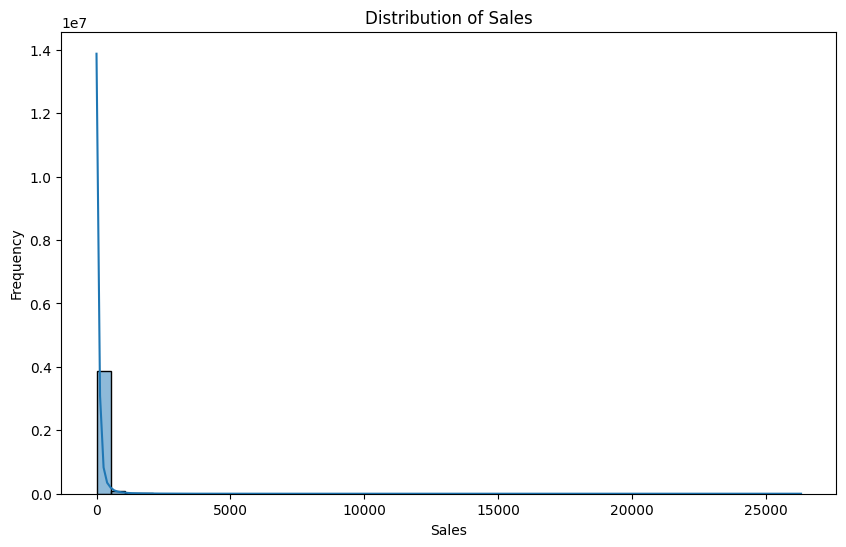

In [16]:
# Distribution of sales
plt.figure(figsize=(10, 6))
sns.histplot(sales_train['sales'], kde=True, bins=50)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

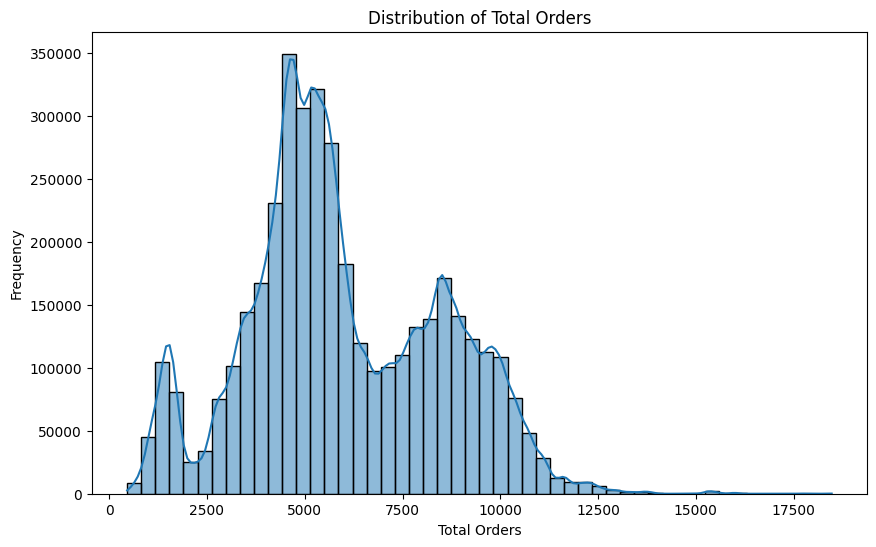

In [17]:
# Distribution of total orders
plt.figure(figsize=(10, 6))
sns.histplot(sales_train['total_orders'], kde=True, bins=50)
plt.title('Distribution of Total Orders')
plt.xlabel('Total Orders')
plt.ylabel('Frequency')
plt.show()

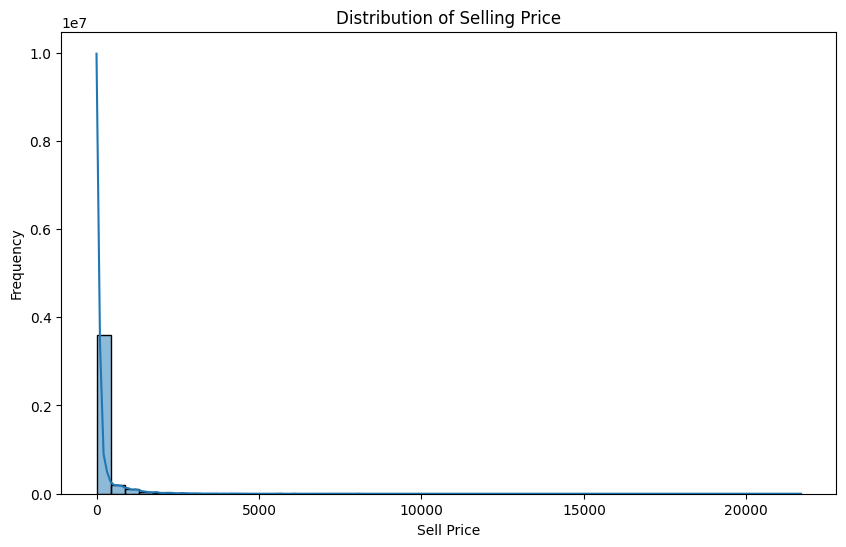

In [18]:
# Distribution of selling price
plt.figure(figsize=(10, 6))
sns.histplot(sales_train['sell_price_main'], kde=True, bins=50)
plt.title('Distribution of Selling Price')
plt.xlabel('Sell Price')
plt.ylabel('Frequency')
plt.show()

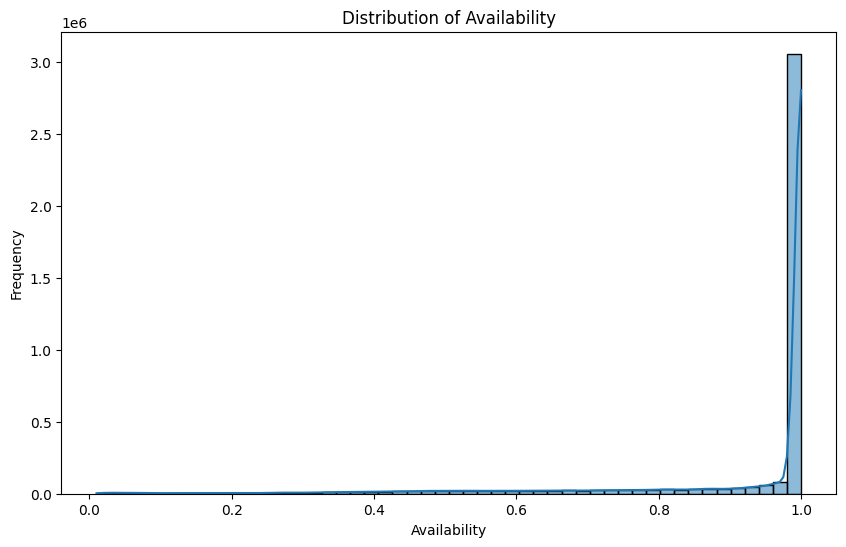

In [19]:
# Distribution of availability
plt.figure(figsize=(10, 6))
sns.histplot(sales_train['availability'], kde=True, bins=50)
plt.title('Distribution of Availability')
plt.xlabel('Availability')
plt.ylabel('Frequency')
plt.show()

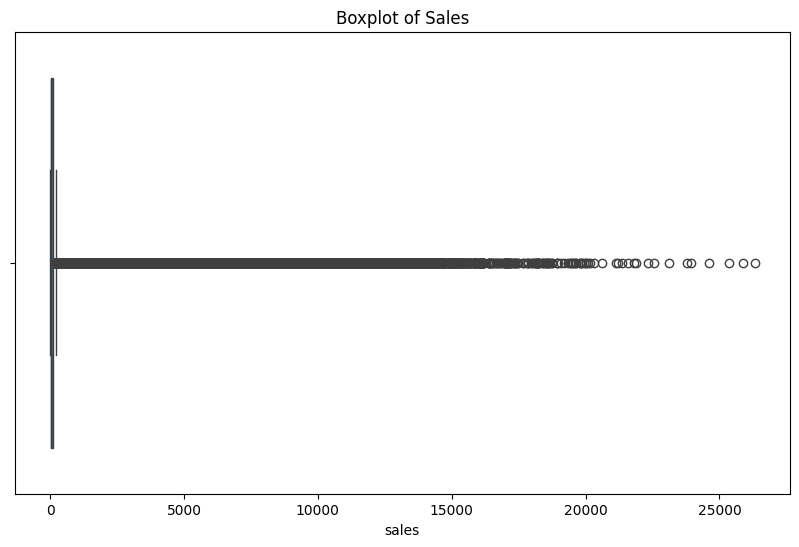

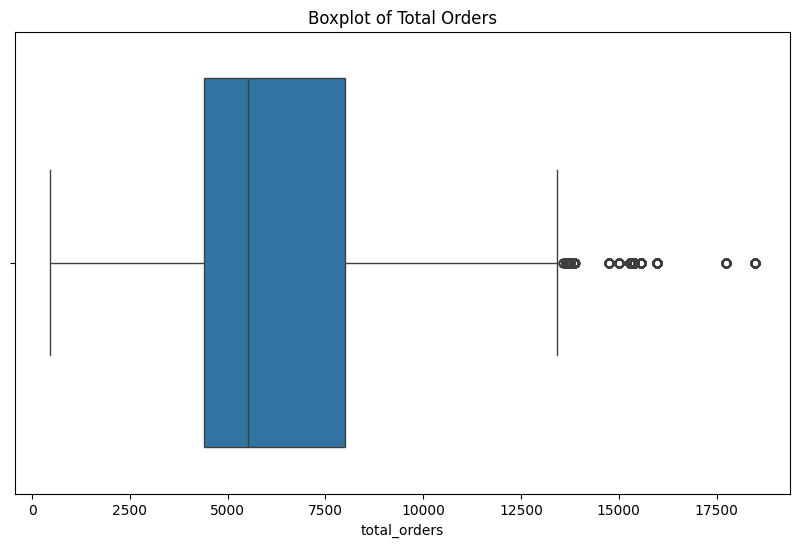

In [20]:
# Boxplot to detect outliers for sales
plt.figure(figsize=(10, 6))
sns.boxplot(x=sales_train['sales'])
plt.title('Boxplot of Sales')
plt.show()

# Boxplot to detect outliers for total orders
plt.figure(figsize=(10, 6))
sns.boxplot(x=sales_train['total_orders'])
plt.title('Boxplot of Total Orders')
plt.show()

Time-based Analysis****

In [21]:
#Sales over Time
# Set 'date' as index for time series analysis
sales_train.set_index('date', inplace=True)

/var/folders/bp/58n4rcr11g7fr8h3gjd96p640000gn/T/ipykernel_27903/1410698231.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = sales_train['sales'].resample('M').sum()


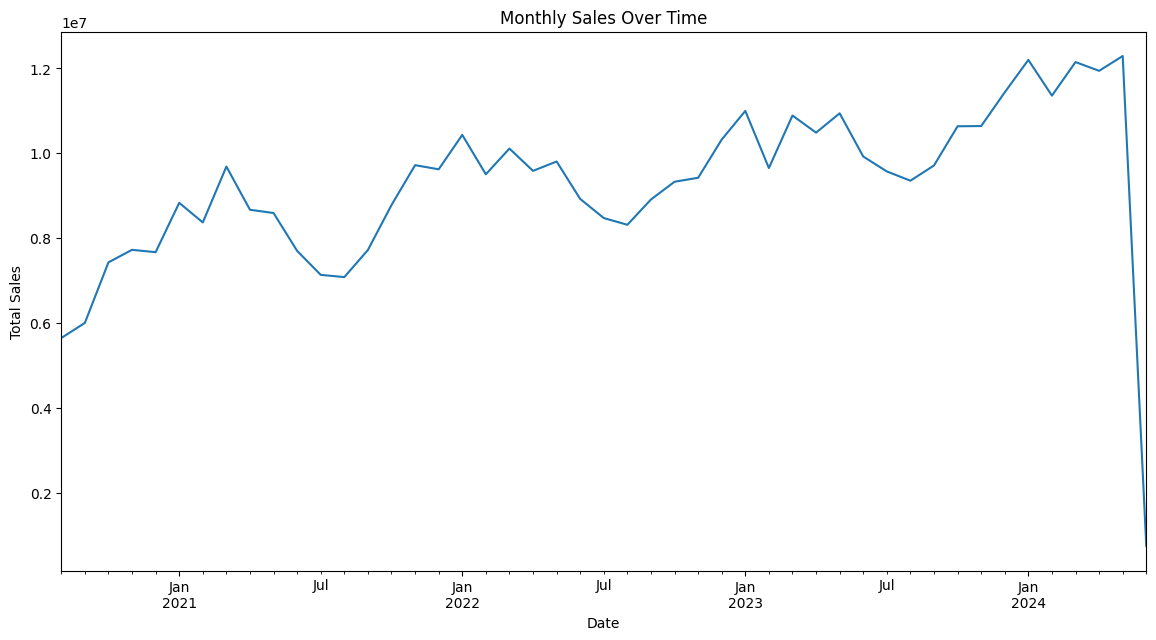

In [22]:
# Plot sales over time (aggregate by month)
monthly_sales = sales_train['sales'].resample('M').sum()
# .resample('M') groups the data by month
plt.figure(figsize=(14, 7))
monthly_sales.plot()
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

/var/folders/bp/58n4rcr11g7fr8h3gjd96p640000gn/T/ipykernel_27903/257693769.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  monthly_sales = sales_train['sales'].resample('Y').sum()


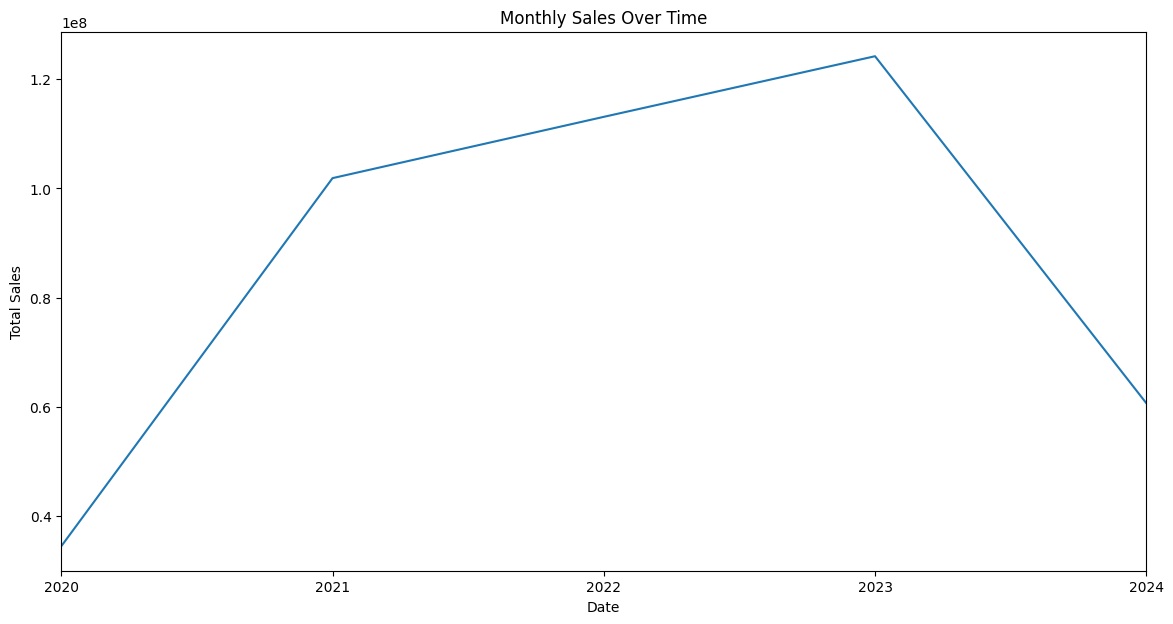

In [23]:
# Plot sales over time (aggregate by month)
monthly_sales = sales_train['sales'].resample('Y').sum()
# .resample('M') groups the data by month
plt.figure(figsize=(14, 7))
monthly_sales.plot()
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

/var/folders/bp/58n4rcr11g7fr8h3gjd96p640000gn/T/ipykernel_27903/1833149501.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_orders = sales_train['total_orders'].resample('M').sum()


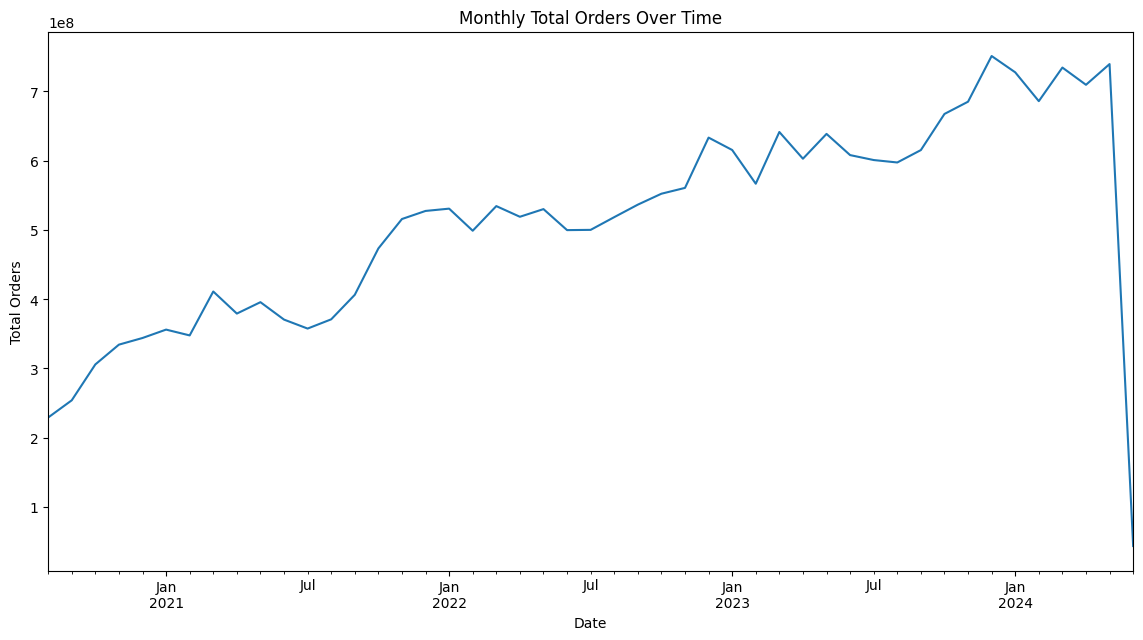

In [24]:
#Total Orders over Time
# Plot total orders over time (aggregate by month)
monthly_orders = sales_train['total_orders'].resample('M').sum()
plt.figure(figsize=(14, 7))
monthly_orders.plot()
plt.title('Monthly Total Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Total Orders')
plt.show()

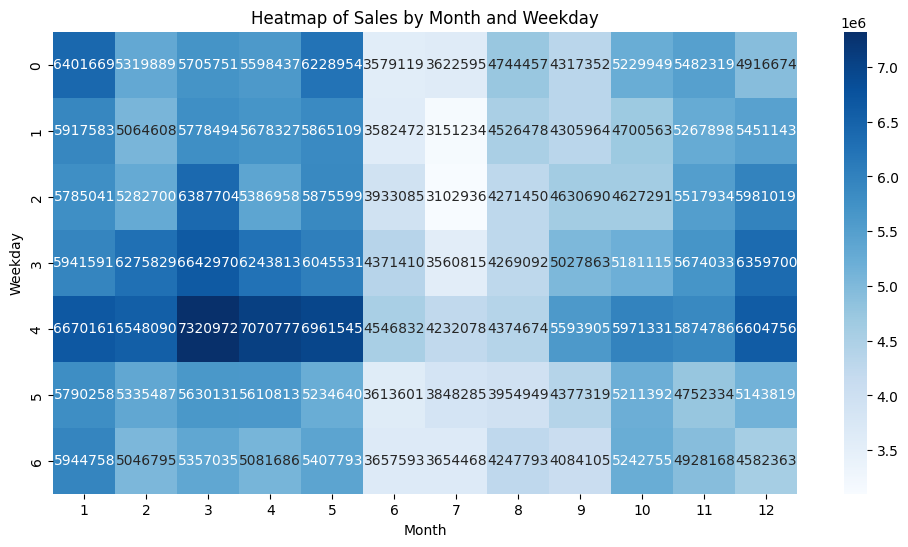

In [25]:
#Heatmap of Sales by Month and Day of Week
# Extract month and weekday from the date
sales_train['month'] = sales_train.index.month
sales_train['weekday'] = sales_train.index.weekday

# Pivot table for heatmap: sum of sales by month and weekday
sales_heatmap = sales_train.pivot_table(values='sales', index='weekday', columns='month', aggfunc='sum')

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sales_heatmap, cmap='Blues', annot=True, fmt='.0f', cbar=True)
plt.title('Heatmap of Sales by Month and Weekday')
plt.xlabel('Month')
plt.ylabel('Weekday')
plt.show()


Bivariate Analysis (Relationships between Features)****

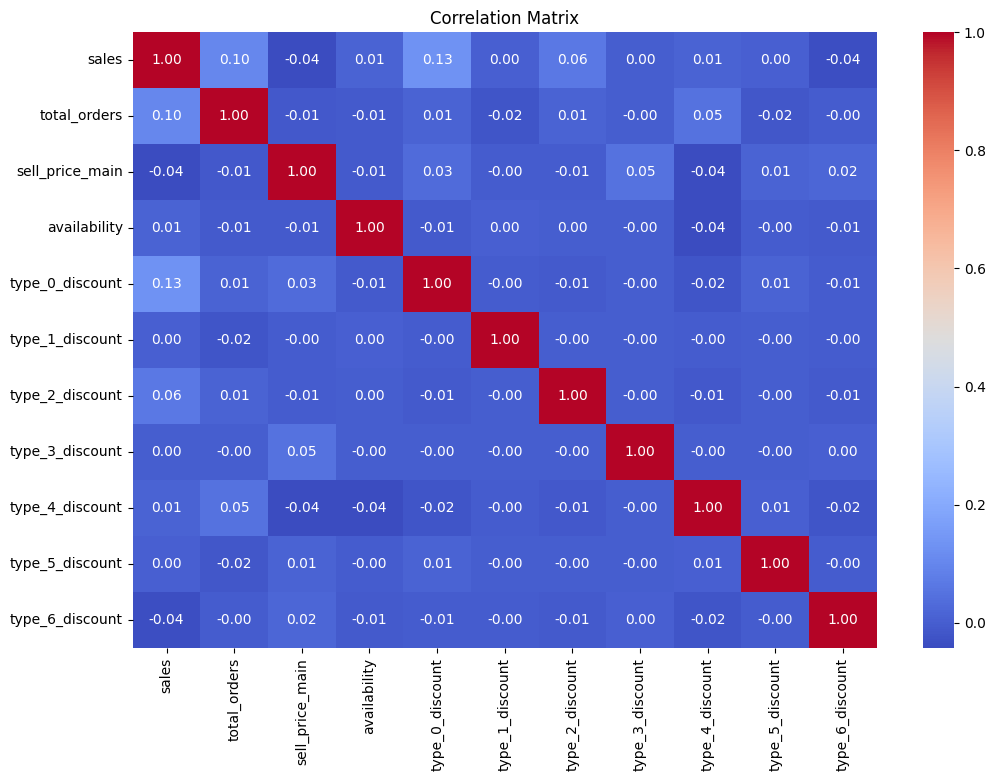

In [26]:
# Compute correlations between numerical features
correlation_matrix = sales_train[['sales', 'total_orders', 'sell_price_main', 'availability', 'type_0_discount', 
                                  'type_1_discount', 'type_2_discount', 'type_3_discount', 'type_4_discount', 
                                  'type_5_discount', 'type_6_discount']].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [27]:
# remove the date index to avoid issues with the next steps
sales_train.reset_index(inplace=True)
sales_train.head()

,date,unique_id,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,...,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday,holiday_name,shops_closed,winter_school_holidays,school_holidays,month,weekday
0,2024-03-10,4845,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,...,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,NaN,0,0,0,3,6
1,2021-05-25,4845,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,...,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,NaN,0,0,0,5,1
2,2021-12-20,4845,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,...,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,NaN,0,0,0,12,0
3,2023-04-29,4845,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,...,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,NaN,0,0,0,4,5
4,2022-04-01,4845,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,...,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,NaN,0,0,0,4,4


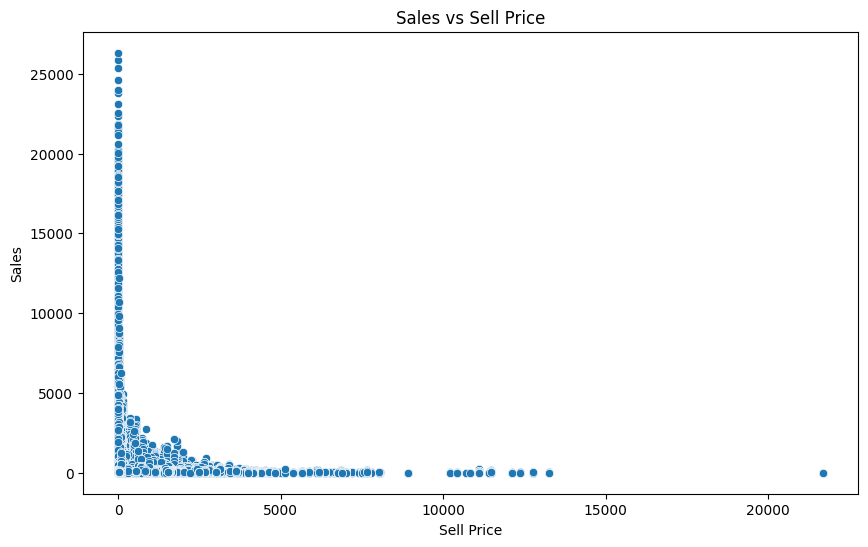

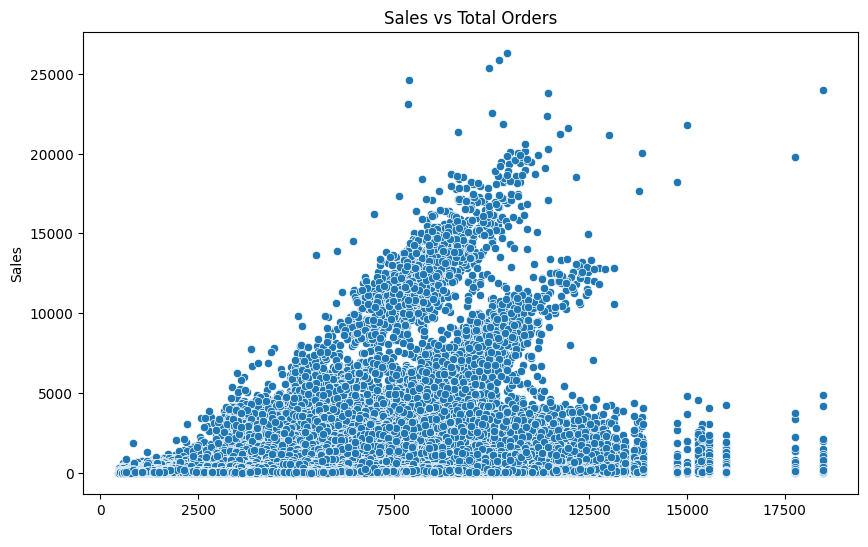

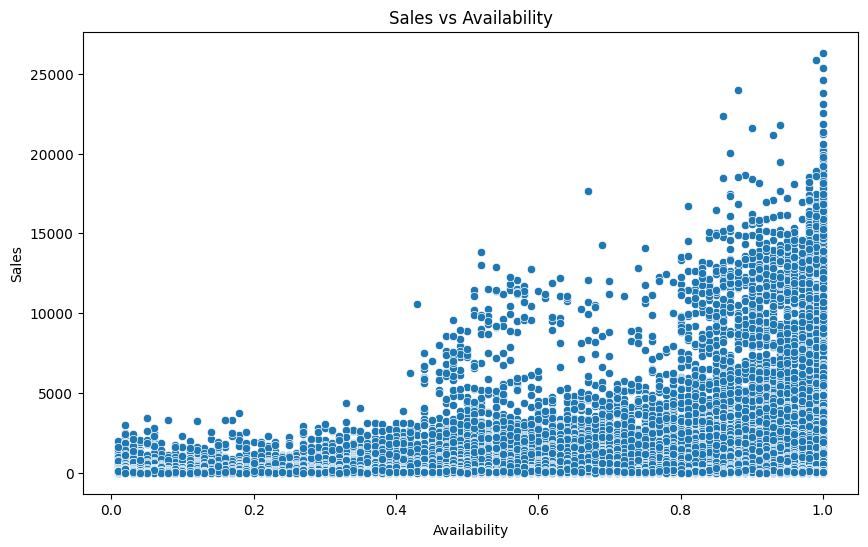

In [28]:
# Sales vs Sell Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x=sales_train['sell_price_main'], y=sales_train['sales'])
plt.title('Sales vs Sell Price')
plt.xlabel('Sell Price')
plt.ylabel('Sales')
plt.show()

# Sales vs Total Orders
plt.figure(figsize=(10, 6))
sns.scatterplot(x=sales_train['total_orders'], y=sales_train['sales'])
plt.title('Sales vs Total Orders')
plt.xlabel('Total Orders')
plt.ylabel('Sales')
plt.show()

# Sales vs Availability
plt.figure(figsize=(10, 6))
sns.scatterplot(x=sales_train['availability'], y=sales_train['sales'])
plt.title('Sales vs Availability')
plt.xlabel('Availability')
plt.ylabel('Sales')
plt.show()


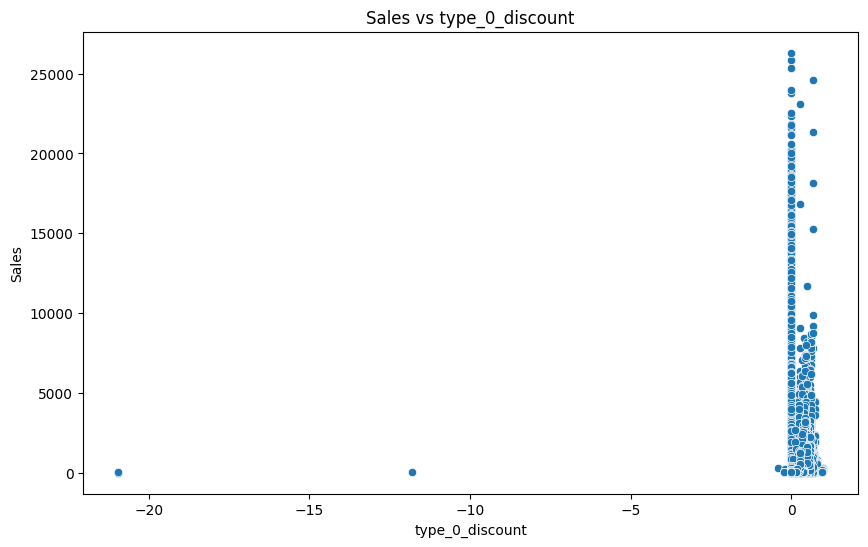

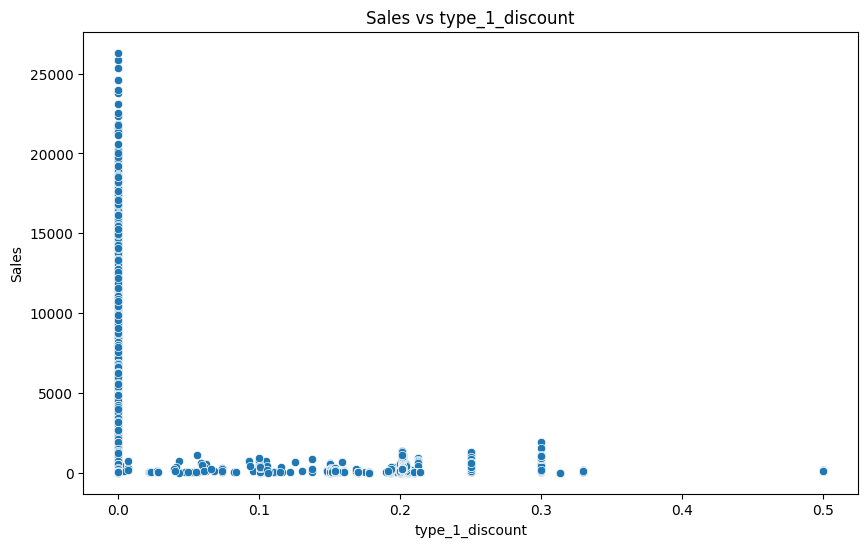

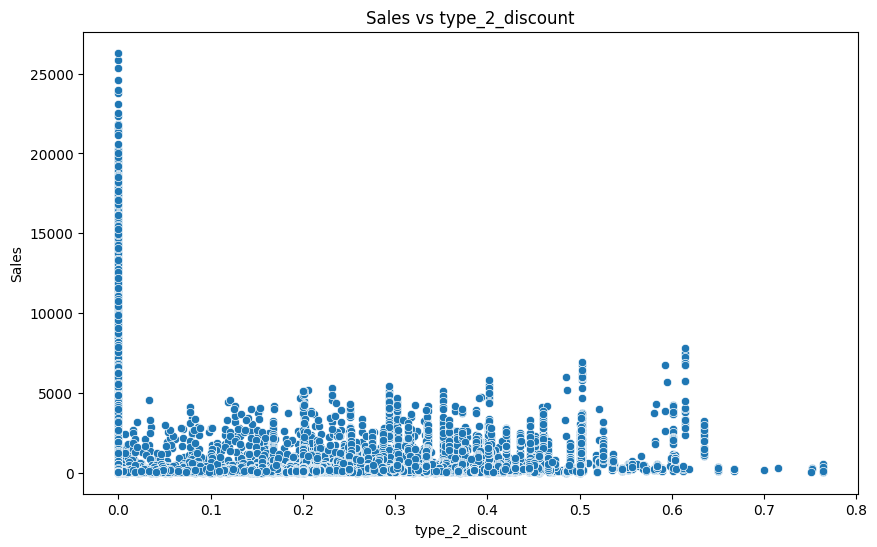

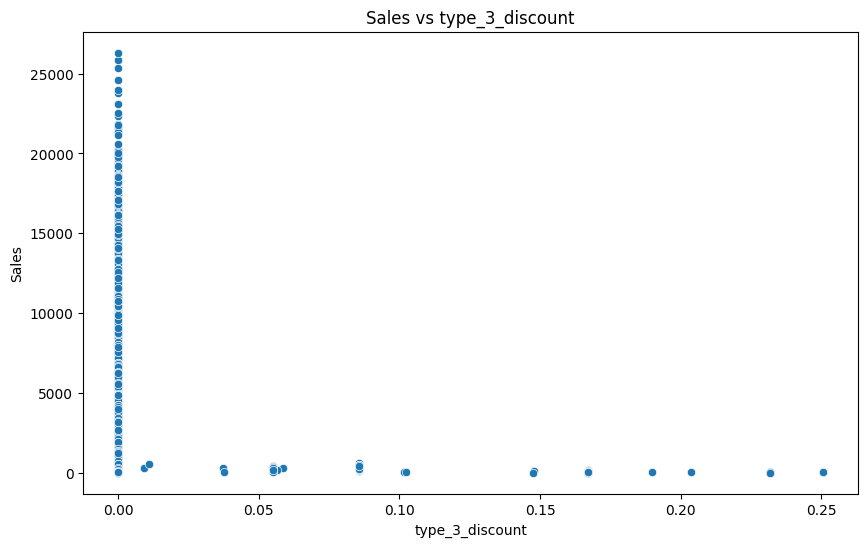

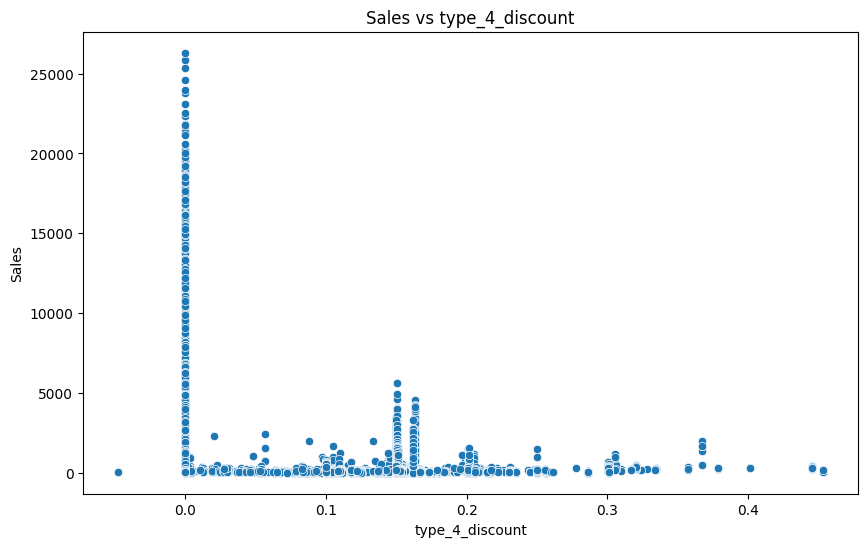

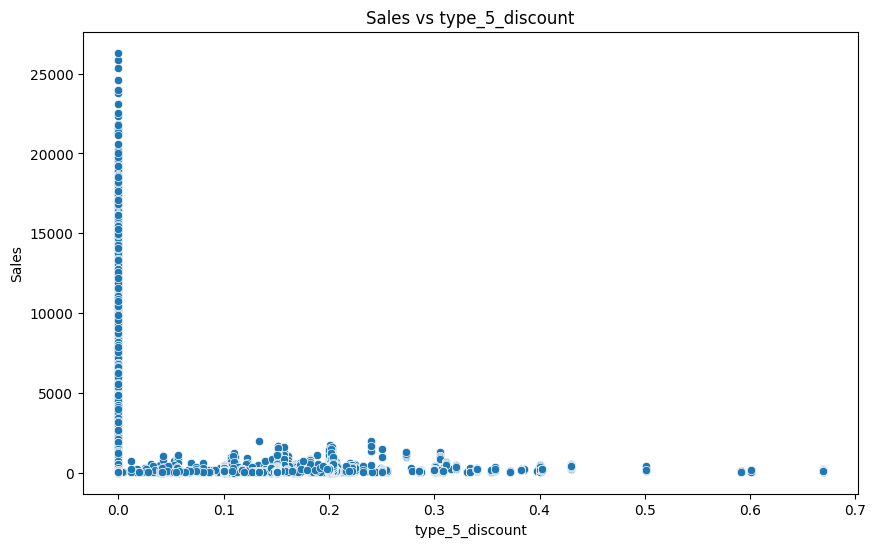

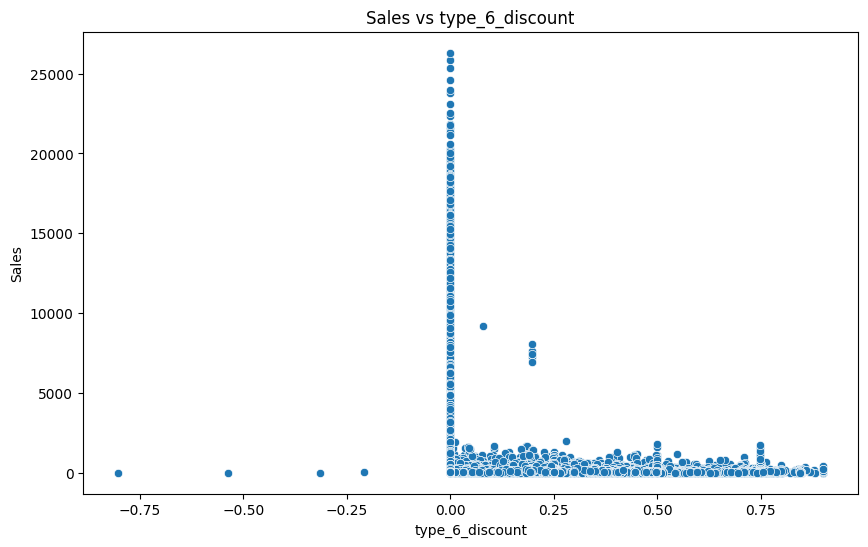

In [29]:
# Scatter plot of each discount type vs Sales
discount_columns = ['type_0_discount', 'type_1_discount', 'type_2_discount', 'type_3_discount', 
                    'type_4_discount', 'type_5_discount', 'type_6_discount']

for col in discount_columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=sales_train[col], y=sales_train['sales'])
    plt.title(f'Sales vs {col}')
    plt.xlabel(col)
    plt.ylabel('Sales')
    plt.show()


Categorical Features Exploration****

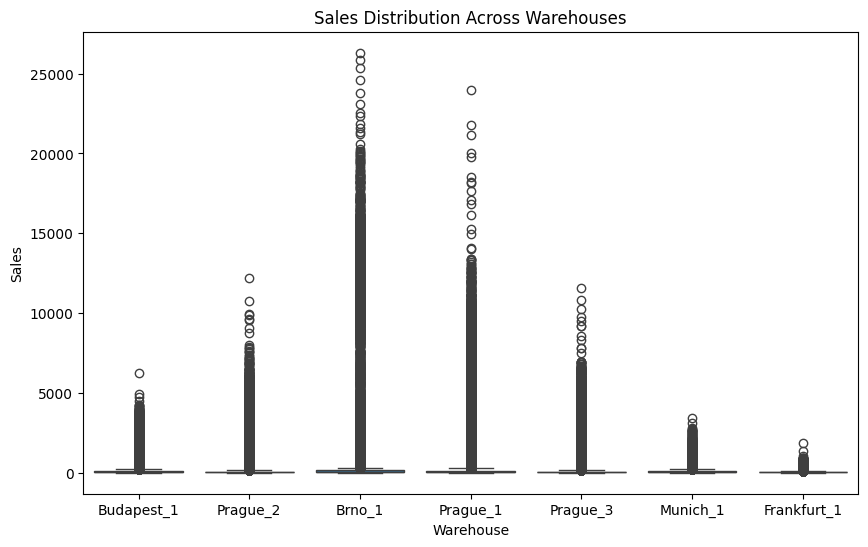

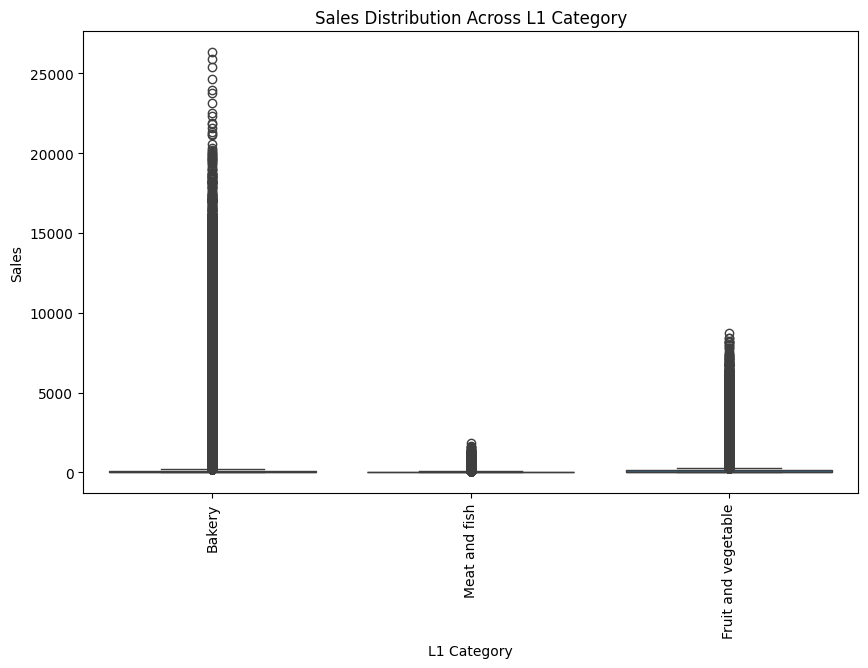

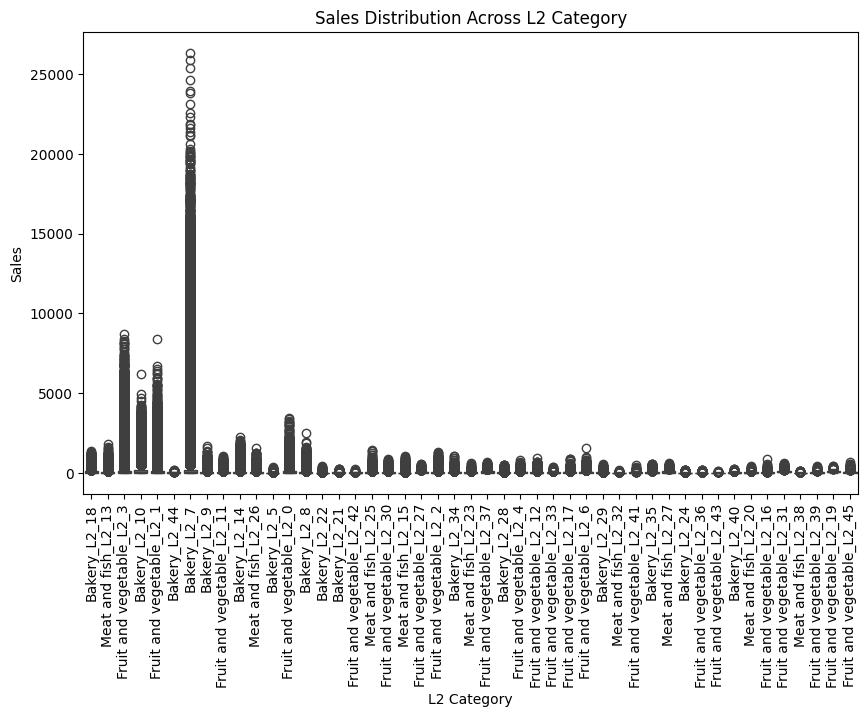

In [30]:
# Sales across warehouse types
plt.figure(figsize=(10, 6))
sns.boxplot(x=sales_train['warehouse'], y=sales_train['sales'])
plt.title('Sales Distribution Across Warehouses')
plt.xlabel('Warehouse')
plt.ylabel('Sales')
plt.show()

# Sales across L1 category
plt.figure(figsize=(10, 6))
sns.boxplot(x=sales_train['L1_category_name_en'], y=sales_train['sales'])
plt.title('Sales Distribution Across L1 Category')
plt.xlabel('L1 Category')
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.show()

# Sales across L2 category
plt.figure(figsize=(10, 6))
sns.boxplot(x=sales_train['L2_category_name_en'], y=sales_train['sales'])
plt.title('Sales Distribution Across L2 Category')
plt.xlabel('L2 Category')
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.show()


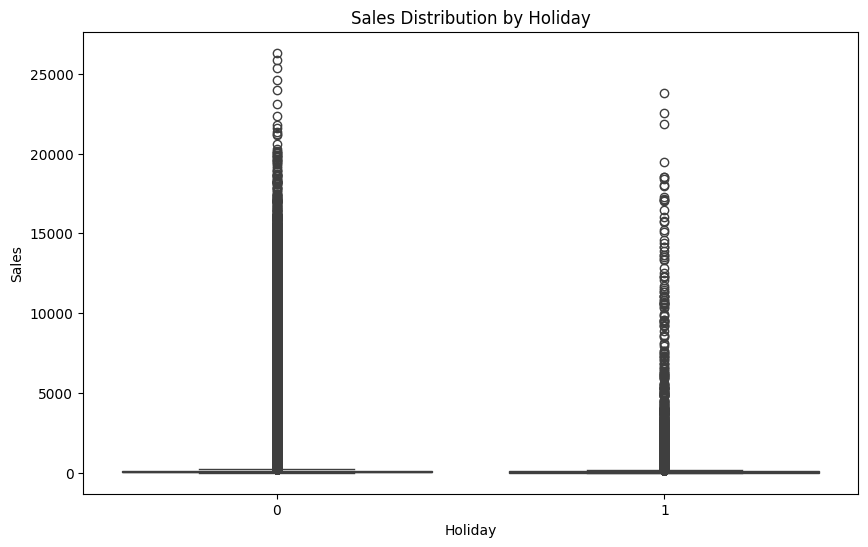

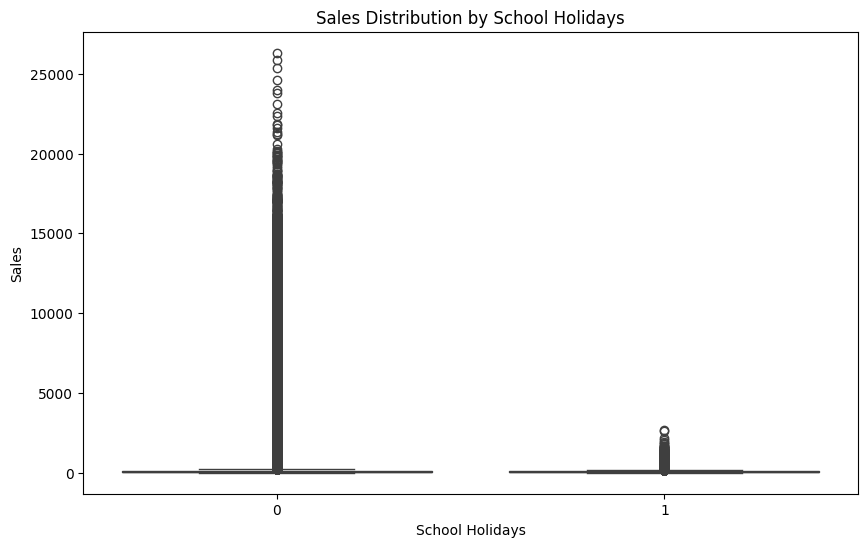

In [31]:
# Sales by holiday presence
plt.figure(figsize=(10, 6))
sns.boxplot(x=sales_train['holiday'], y=sales_train['sales'])
plt.title('Sales Distribution by Holiday')
plt.xlabel('Holiday')
plt.ylabel('Sales')
plt.show()

# Sales by school holidays
plt.figure(figsize=(10, 6))
sns.boxplot(x=sales_train['school_holidays'], y=sales_train['sales'])
plt.title('Sales Distribution by School Holidays')
plt.xlabel('School Holidays')
plt.ylabel('Sales')
plt.show()


**Explore seasonal trends**

In [32]:
#Sales over Time
# Set 'date' as index for time series analysis
sales_train.set_index('date', inplace=True)

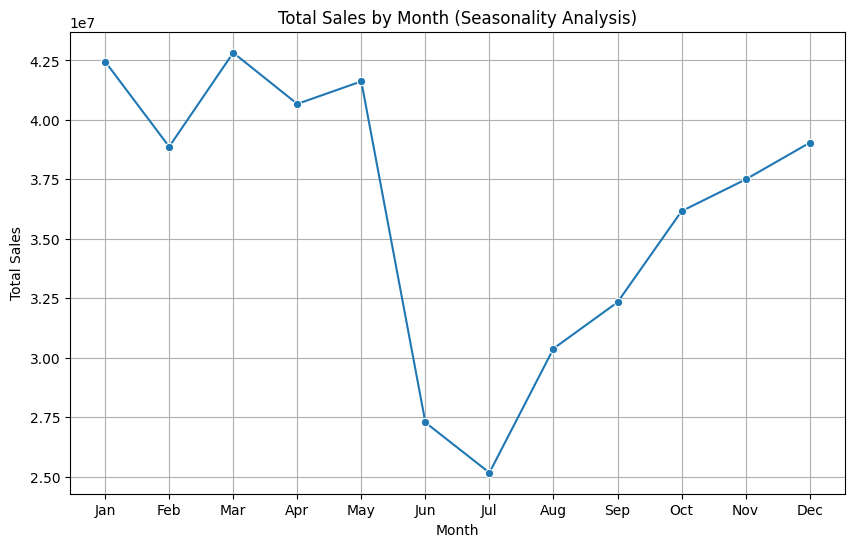

In [33]:
# Aggregate sales by month
sales_train['month'] = sales_train.index.month
monthly_sales = sales_train.groupby('month')['sales'].sum()

# Plot the monthly sales trend
plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker='o')
plt.title('Total Sales by Month (Seasonality Analysis)')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(ticks=np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()


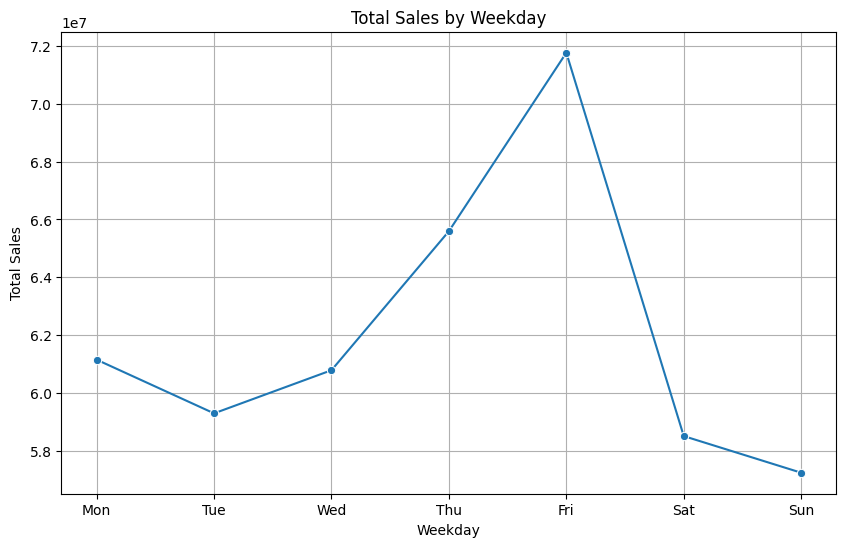

In [34]:
# Extract weekday from the date (0 = Monday, 6 = Sunday)
sales_train['weekday'] = sales_train.index.weekday

# Aggregate sales by weekday
weekday_sales = sales_train.groupby('weekday')['sales'].sum()

# Plot sales by weekday
plt.figure(figsize=(10, 6))
sns.lineplot(x=weekday_sales.index, y=weekday_sales.values, marker='o')
plt.title('Total Sales by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Total Sales')
plt.xticks(ticks=np.arange(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True)
plt.show()


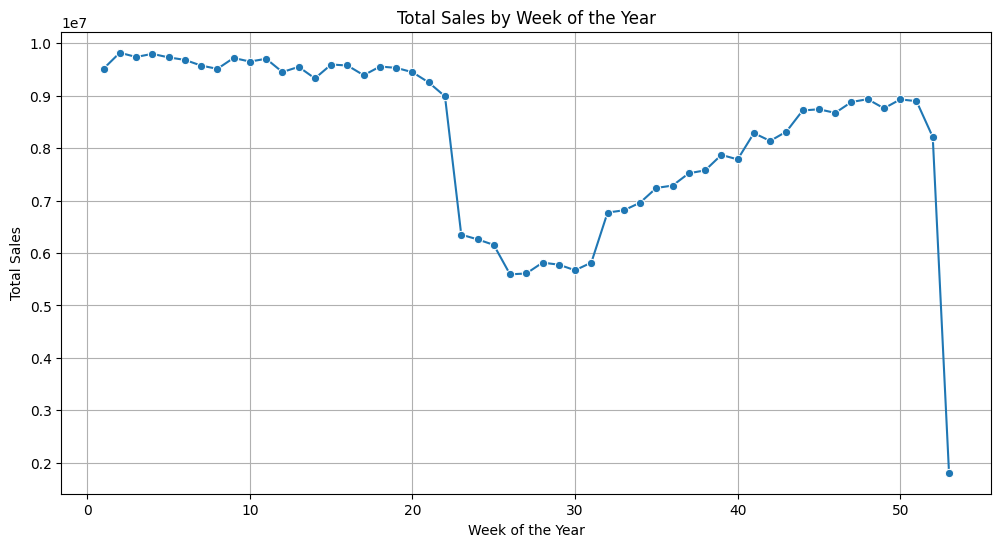

In [35]:
# Extract week of the year
sales_train['week_of_year'] = sales_train.index.isocalendar().week

# Aggregate sales by week of the year
weekly_sales = sales_train.groupby('week_of_year')['sales'].sum()

# Plot weekly sales trend
plt.figure(figsize=(12, 6))
sns.lineplot(x=weekly_sales.index, y=weekly_sales.values, marker='o')
plt.title('Total Sales by Week of the Year')
plt.xlabel('Week of the Year')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()


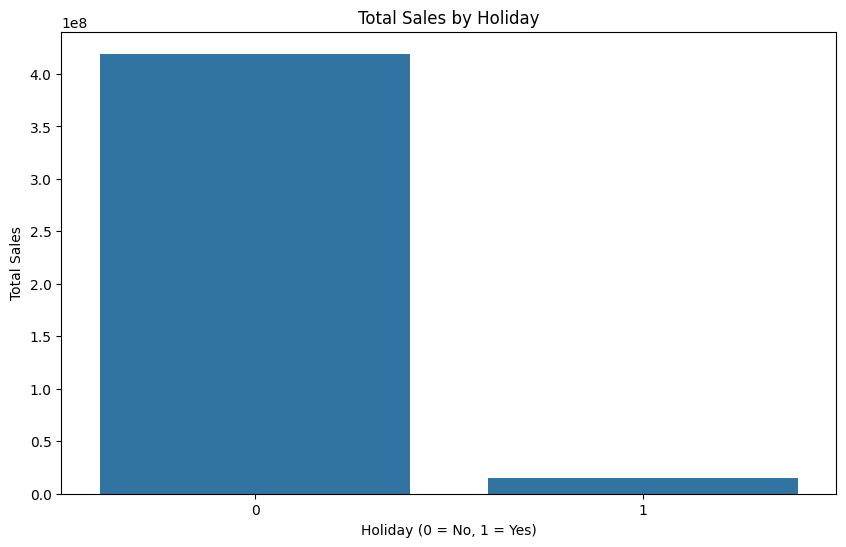

In [36]:
# Aggregate sales based on holiday status (1 = holiday, 0 = no holiday)
holiday_sales = sales_train.groupby('holiday')['sales'].sum()

# Plot holiday sales
plt.figure(figsize=(10, 6))
sns.barplot(x=holiday_sales.index, y=holiday_sales.values)
plt.title('Total Sales by Holiday')
plt.xlabel('Holiday (0 = No, 1 = Yes)')
plt.ylabel('Total Sales')
plt.show()


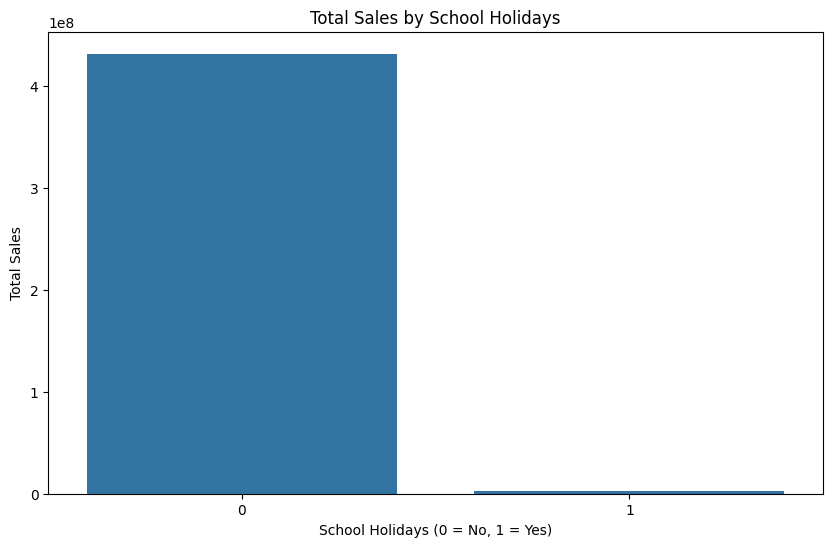

In [37]:
# Aggregate sales based on school holidays
school_holiday_sales = sales_train.groupby('school_holidays')['sales'].sum()

# Plot school holiday sales
plt.figure(figsize=(10, 6))
sns.barplot(x=school_holiday_sales.index, y=school_holiday_sales.values)
plt.title('Total Sales by School Holidays')
plt.xlabel('School Holidays (0 = No, 1 = Yes)')
plt.ylabel('Total Sales')
plt.show()


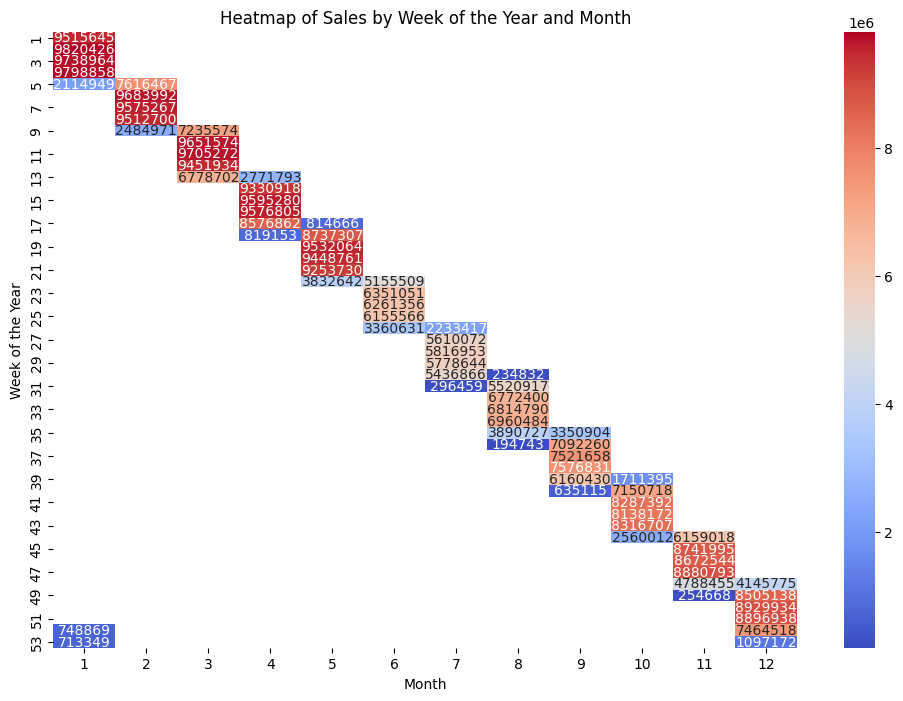

In [38]:
# Pivot table for heatmap: sum of sales by week of the year and month
sales_heatmap_seasonal = sales_train.pivot_table(values='sales', index='week_of_year', columns='month', aggfunc='sum')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(sales_heatmap_seasonal, cmap='coolwarm', annot=True, fmt='.0f', cbar=True)
plt.title('Heatmap of Sales by Week of the Year and Month')
plt.xlabel('Month')
plt.ylabel('Week of the Year')
plt.show()


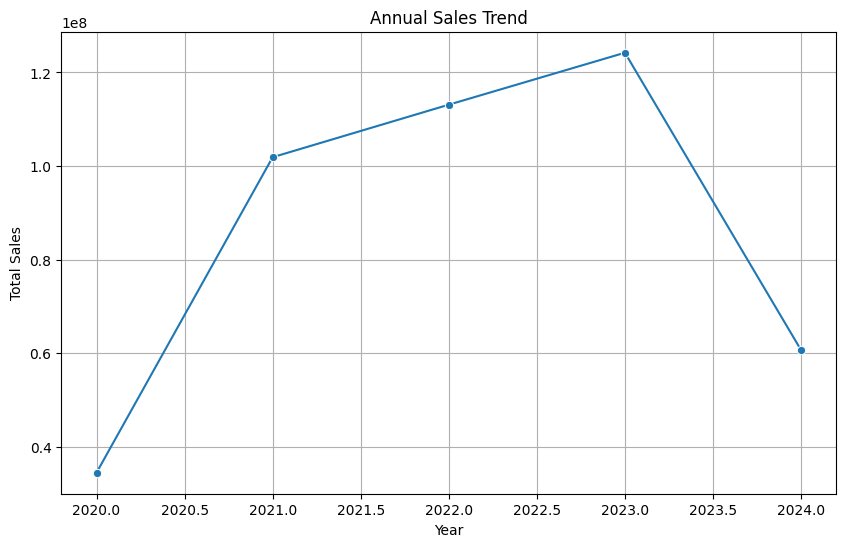

In [39]:
# Extract the year
sales_train['year'] = sales_train.index.year

# Aggregate sales by year
annual_sales = sales_train.groupby('year')['sales'].sum()

# Plot annual sales trends
plt.figure(figsize=(10, 6))
sns.lineplot(x=annual_sales.index, y=annual_sales.values, marker='o')
plt.title('Annual Sales Trend')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()


Seasonal Decomposition****

This will show four plots:

    Observed: The original sales data.
    Trend: The long-term trend component.
    Seasonal: The seasonal fluctuations.
    Residual: The noise or residual part of the data (i.e., what's left after removing the trend and seasonality).

/var/folders/bp/58n4rcr11g7fr8h3gjd96p640000gn/T/ipykernel_27903/389198966.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = sales_train['sales'].resample('M').sum()


<Figure size 1400x800 with 0 Axes>

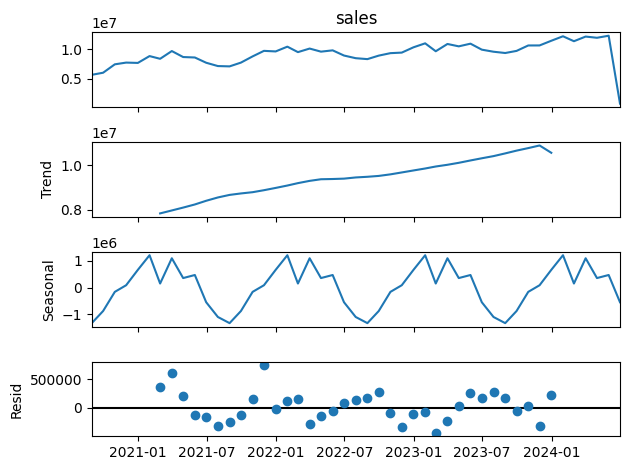

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Resample sales data to monthly for decomposition
monthly_sales = sales_train['sales'].resample('M').sum()

# Perform seasonal decomposition
decomposition = seasonal_decompose(monthly_sales, model='additive', period=12) #model='multiplicative'

# Plot decomposition
plt.figure(figsize=(14, 8))
decomposition.plot()
plt.show()


**The analysises below may take to much time**

In [43]:
# remove the date index to avoid issues with the next steps
sales_train.reset_index(inplace=True)
sales_train.head()

,index,date,unique_id,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,...,L4_category_name_en,holiday,holiday_name,shops_closed,winter_school_holidays,school_holidays,month,weekday,week_of_year,year
0,0,2024-03-10,4845,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,...,Bakery_L4_1,0,NaN,0,0,0,3,6,10,2024
1,1,2021-05-25,4845,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,...,Bakery_L4_1,0,NaN,0,0,0,5,1,21,2021
2,2,2021-12-20,4845,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,...,Bakery_L4_1,0,NaN,0,0,0,12,0,51,2021
3,3,2023-04-29,4845,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,...,Bakery_L4_1,0,NaN,0,0,0,4,5,17,2023
4,4,2022-04-01,4845,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,...,Bakery_L4_1,0,NaN,0,0,0,4,4,13,2022


**Stationarity Tests (ADF Test)**

Checking stationarity is important for regression-based models. Used the Augmented Dickey-Fuller (ADF) test to assess whether time series is stationary. If not, differencing or other transformations may be needed.

In [44]:
#from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
#result = adfuller(sales_train['sales'].dropna())  # Drop NaNs before testing
#print(f"ADF Statistic: {result[0]}")
#print(f"p-value: {result[1]}")

# If p-value > 0.05, the series is likely non-stationary and may require differencing



**Change Point Detection**

Change point detection can help identify sudden shifts in the sales data, possibly due to events like new product launches or marketing campaigns.

In [45]:
#!pip install ruptures  # Install ruptures if not already installed
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#from ruptures import Pelt

# Ensure 'sales' column is numeric and drop missing values
#sales_data = sales_train['sales'].dropna().values  # Convert to 1D NumPy array

# Apply change point detection
#model = "l2"  # Model type for change point detection
#algo = Pelt(model=model).fit(sales_data)  # Fit the model
#result = algo.predict(pen=10)  # Penalty parameter to control the number of change points

# Plot the change points
#plt.figure(figsize=(12, 6))
#plt.plot(sales_data, label='Sales Data')
#for cp in result:
#    plt.axvline(x=cp, color='r', linestyle='--', label='Change Point' if cp == result[0] else "")
#plt.title("Change Points in Sales Data")
#plt.xlabel("Time Index")
#plt.ylabel("Sales")
#plt.legend()
#plt.show()